# Add the lasa.py file in same directory as the jupyter notebook

In [1]:
!pip install gmr
import numpy as np
import matplotlib.pyplot as plt
from lasa import load_lasa
import gmr

## Helper Functions for plotting and loading data

In [2]:
def plot_curves(x, show_start_end=True, **kwargs):
    """
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    """
    if show_start_end:
        start_label, end_label = "start", "end"
    else:
        start_label, end_label = None, None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0, 0], x[t][0, 1], c="k", label=start_label)
        plt.scatter(x[t][-1, 0], x[t][-1, 1], c="b", label=end_label)
        plt.plot(x[t][:, 0], x[t][:, 1], **kwargs)
        if t == 0:
            kwargs.pop("label", None)
            start_label, end_label = None, None

    plt.legend()


def streamplot(f, x_axis=(0, 100), y_axis=(0, 100), n=1000, width=1, **kwargs):
    """
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    """
    a, b = np.linspace(x_axis[0], x_axis[1], n), np.linspace(y_axis[0], y_axis[1], n)
    X, Y = np.meshgrid(a, b)
    X_test = np.stack([X, Y], axis=-1).reshape(-1, 2)
    Y_pred = f(X_test)
    U, V = np.split(Y_pred.reshape(n, n, 2), 2, axis=-1)
    U, V = U[..., 0], V[..., 0]
    speed = np.sqrt(U**2 + V**2)
    lw = width * speed / speed.max()
    plt.streamplot(X, Y, U, V, linewidth=lw, **kwargs)


# gets the velocity x_dot given x
def derivative(x):
    """
    difference method for calculating derivative

    params:
      x: array of shape (number of trajectories,number of timesteps,2)

    returns
      xd: array of shape (number of trajectories,number of timesteps,2)
    """
    xds = []

    for i in range(x.shape[0]):
        dt = 1 / (x[i].shape[0] - 1)
        xd = np.vstack((np.diff(x[i], axis=0) / dt, np.zeros((1, x[i].shape[1]))))
        v_factor = np.cos(np.linspace(0, np.pi / 2, len(xd))) ** 2
        xd = xd * (v_factor[..., None])
        xds.append(xd)
    xd = np.stack(xds)
    return xd


# loading the data and plotting
def load_data(letter):
    """
    gets the trajectories coresponding to the given letter

    params:
      letter: character in ["c","j","s"]

    returns:
      data: array of shape (number of trajectories,number of timesteps,2)
      x: array of shape(number of trajectories*number of timesteps,2)
      xd: array of shape(number of trajectories*number of timesteps,2)

    """
    letter2id = dict(c=2, j=6, s=24)
    assert letter.lower() in letter2id
    _, x, _, _, _, _ = load_lasa(letter2id[letter.lower()])
    xd = derivative(x)
    plot_curves(x)
    data = x
    x = x.reshape(-1, 2)
    xd = xd.reshape(-1, 2)
    plt.show()
    return data, x, xd

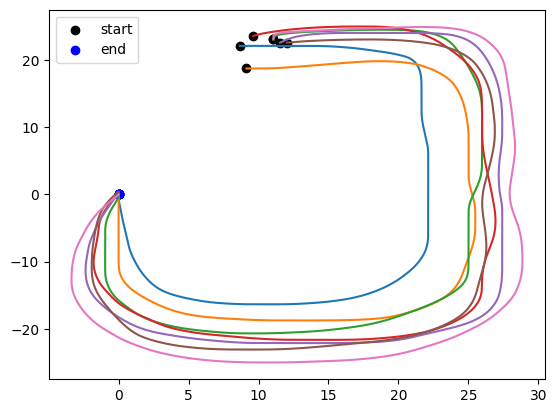

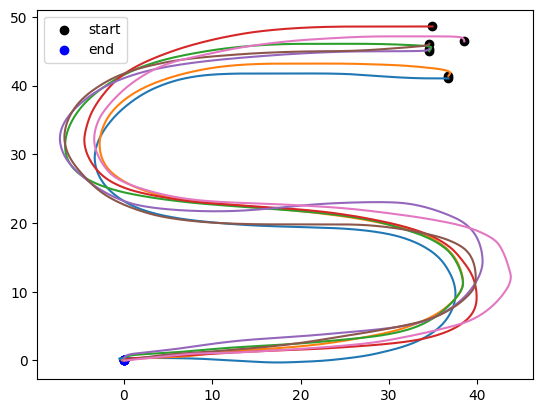

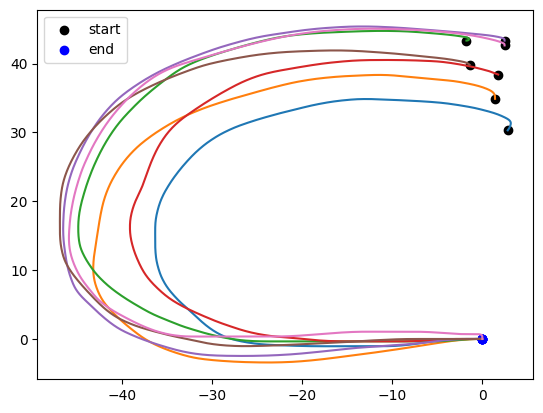

In [3]:
# letter should be one of c,j,s
data, x, xd = load_data("j")
data, x, xd = load_data("s")
data, x, xd = load_data("c")

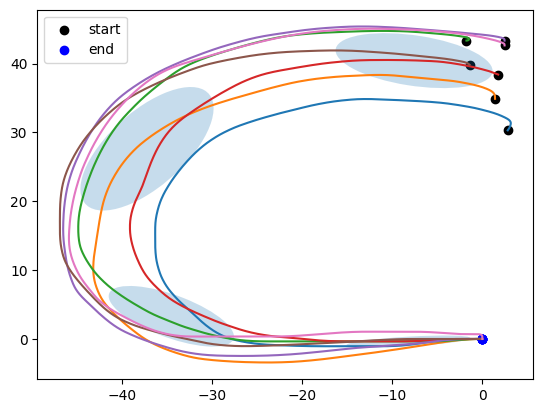

In [4]:
def init_gaussians(y, n=3):
    """
    initializes the gaussian based on time fragmentaion

    params:
        y : array of shape (number of trajectories,number of timesteps,2)
    returns:
        mvns: list of gmr.MVN() initialized objects
    """
    l = y.shape[1] // n
    y_split = [
        y[:, i * l :] if i == n - 1 else y[:, i * l : (i + 1) * l] for i in range(n)
    ]
    mvns = [gmr.MVN().from_samples(x.reshape(-1, 2)) for x in y_split]
    splot = plt.subplot(111)
    plot_curves(y)
    for mvn in mvns:
        gmr.plot_error_ellipse(splot, mvn, factors=[1])
    return mvns


mvns = init_gaussians(data, 4)

In [5]:
class RBFN:
    def __init__(self, mvns, bias=True):
        """
        gaussians for weights
        """
        self.mvns = mvns
        self.bias = bias

    def _compute_activations(self, X):
        """
        Compute activations for each Gaussian basis function.
        """
        activations = np.array(
            [mvn.to_norm_factor_and_exponents(X)[1] for mvn in self.mvns]
        ).T
        return np.exp(activations)

    def fit(self, X, Y):
        """
        store the weight matrix into self.w

        self.w should be array of shape (len(self.mvns)+1,2) if bias is enabled and
        (len(self.mvns),2) if bias is False


        params:
            X: data of shape (n_points,2)
            Y: X_dot of shape(n_points,2)
        """
        ################################
        # YOUR CODE HERE (you can use gmr package or can also write your own functions)

        Phi = self._compute_activations(X)
        if self.bias:
            Phi = np.hstack([Phi, np.ones((Phi.shape[0], 1))])
        self.w = np.linalg.pinv(Phi) @ Y

        ################################

    def predict(self, X):
        """
        returns prediction from the model X_dot

        params:
            X: array of shape (n_points,2)
        returns:
            predicted X_dot: array of shape (n_points,2)
        """
        ################################
        # YOUR CODE HERE (you can use gmr package or can also write your own functions)

        Phi = self._compute_activations(X)
        if self.bias:
            Phi = np.hstack([Phi, np.ones((Phi.shape[0], 1))])
        return Phi @ self.w

        ################################

    def ode_differential(self, x, t):
        """
        function used for rk4 simulation
        """
        return self.predict(x[None])[0]

    def rk4_sim(self, t0, t_end, x0, f, dt=1e-3):
        """
        simlution done with rk4

        Returns
        -------
        x : shape (n_steps,self.d)
        t : shape - (n_steps,)
        """
        # Calculate slopes
        x, t = x0, t0
        x_list, t_list = [x0], [t0]
        while t <= t_end:
            k1 = dt * f(x, t)
            k2 = dt * f(x + k1 / 2.0, t + dt / 2.0)
            k3 = dt * f(x + k2 / 2.0, t + dt / 2.0)
            k4 = dt * f(x + k3, t + dt)

            # Calculate new x and y
            x = x + 1.0 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)

        return np.array(x_list), np.array(t_list)

    def imitate(self, x0, t_end=5):
        """
        imitation with new starting point

        Parameters
        ----------
        x0  - starting point - shape (self.d,)

        Returns
        -------
        x_rk4 - simulated data  - shape (n_steps,self.d)
        t_rk4 - time - shape (n_steps,)
        """
        f = self.ode_differential
        return self.rk4_sim(0, t_end, x0, f)

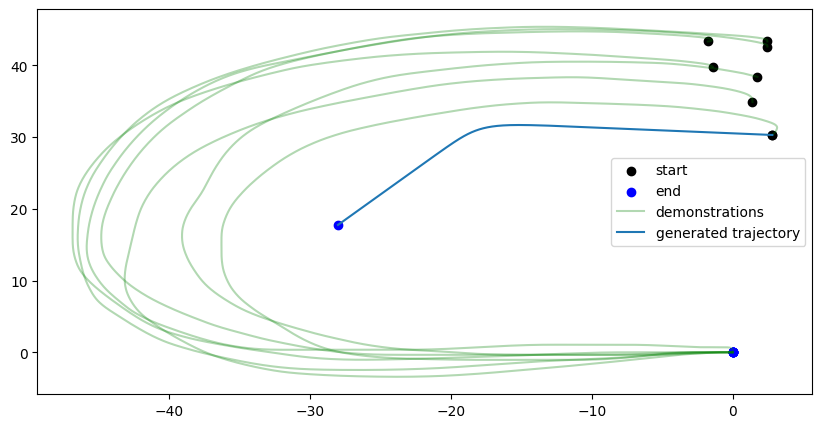

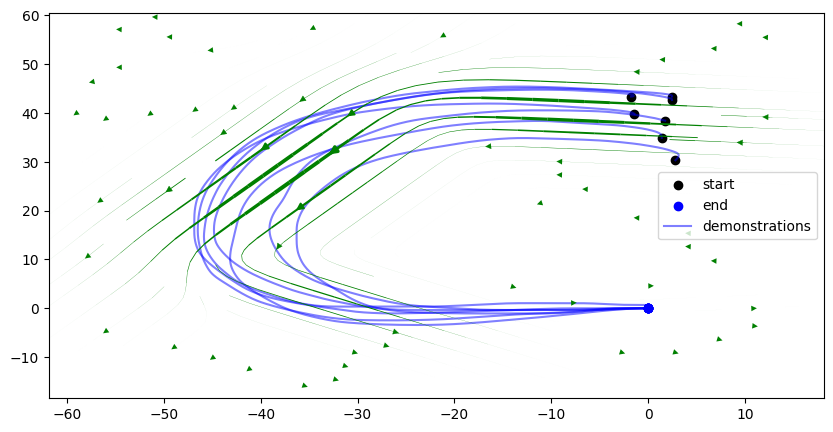

In [6]:
# fitting the model to data
model = RBFN(mvns, bias=False)
model.fit(x, xd)

# starting point for imitation
x0 = data[0][0]
x_rk4, t_tk4 = model.imitate(x0, t_end=10)

# plots for generated trajectory
plt.figure(figsize=(10, 5))
plot_curves(data, alpha=0.3, c="g", label="demonstrations")
plot_curves(x_rk4[None], show_start_end=False, label="generated trajectory")

# vector field plot using stream line
plt.figure(figsize=(10, 5))
plot_curves(data, alpha=0.5, c="b", label="demonstrations")

streamplot(
    model.predict,
    x_axis=(min(x[:, 0]) - 15, max(x[:, 0]) + 15),
    y_axis=(min(x[:, 1]) - 15, max(x[:, 1]) + 15),
    width=3,
    color="g",
)

#Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans:

Q2.Try different initial points, and simulate the process.

Q3.Try changing the number of gaussians and comment on the generalization of the algorithm. \\
Ans:

In [7]:
####################
# YOUR CODE HERE FOR ANSWERING THE ABOVE QUESTIONS


def fit_rbfn(dataset, n=4, bias=False):
    # load data
    data, x, xd = load_data(dataset)

    # initializing gaussians
    mvns = init_gaussians(data, n)

    # fitting the model to data
    model = RBFN(mvns, bias=bias)
    model.fit(x, xd)

    # starting point for imitation
    x0 = data[0][0]
    x_rk4, t_tk4 = model.imitate(x0, t_end=10)

    # plots for generated trajectory
    plt.figure(figsize=(10, 5))
    plot_curves(data, alpha=0.3, c="g", label="demonstrations")
    plot_curves(x_rk4[None], show_start_end=False, label="generated trajectory")

    # vector field plot using stream line
    plt.figure(figsize=(10, 5))
    plot_curves(data, alpha=0.5, c="b", label="demonstrations")

    streamplot(
        model.predict,
        x_axis=(min(x[:, 0]) - 15, max(x[:, 0]) + 15),
        y_axis=(min(x[:, 1]) - 15, max(x[:, 1]) + 15),
        width=3,
        color="g",
    )


####################

## Dataset "C"

### 1. GAS point

#### Plots

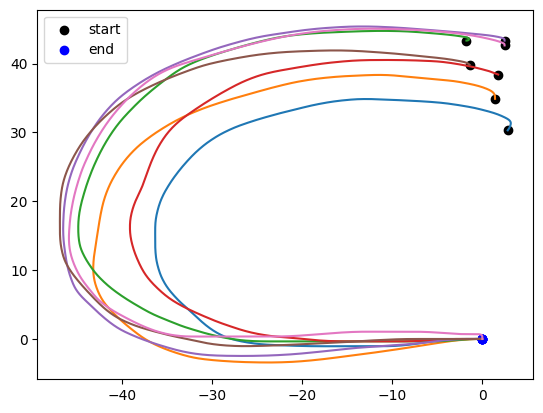

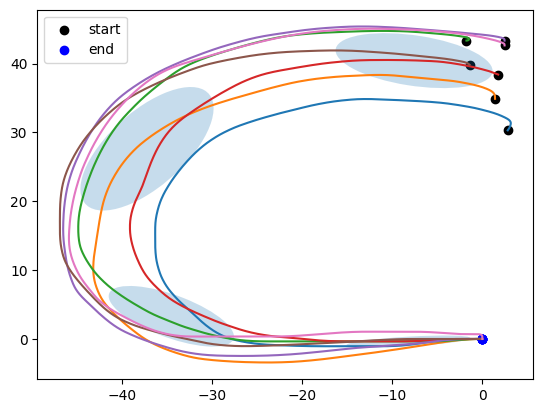

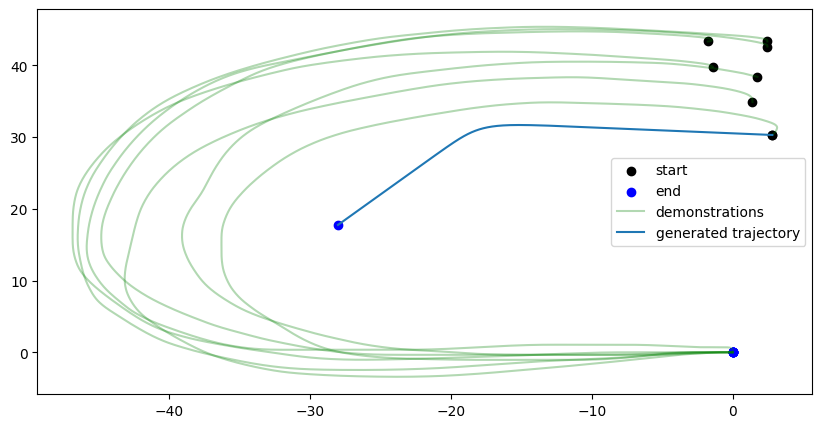

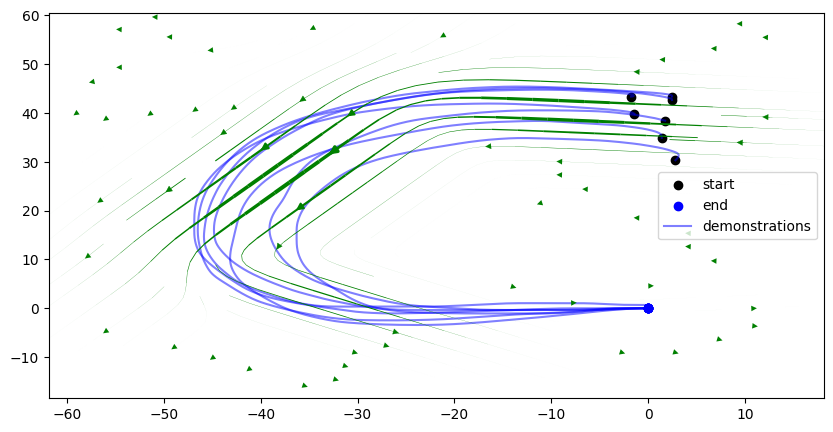

In [8]:
fit_rbfn(dataset="c", n=4, bias=False)

#### Analysis

No, the system doesn't have a global asymptotic stable point.

As seen from the vector field, the arrows are diverging near the outer areas of the plot. 

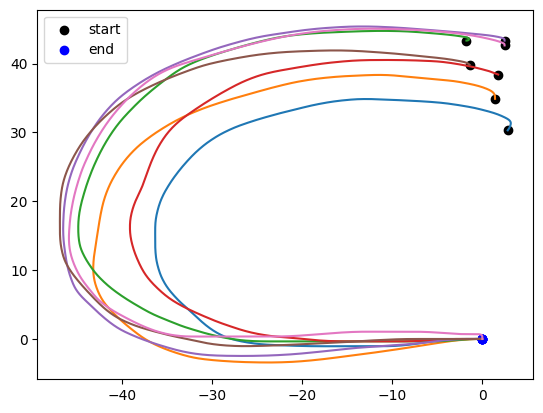

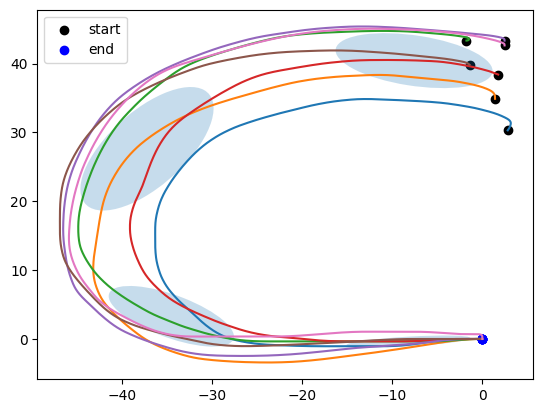

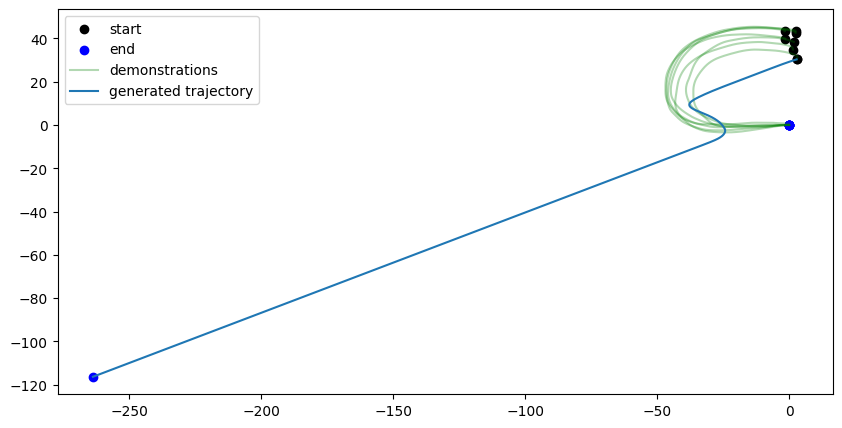

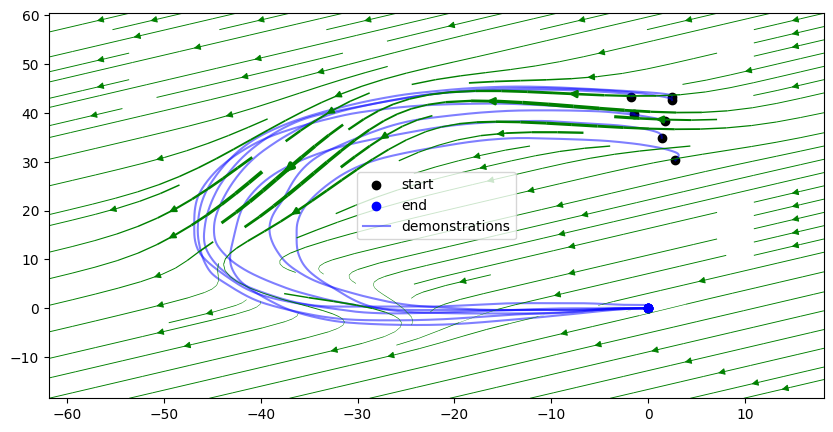

In [9]:
fit_rbfn(dataset="c", n=4, bias=True)

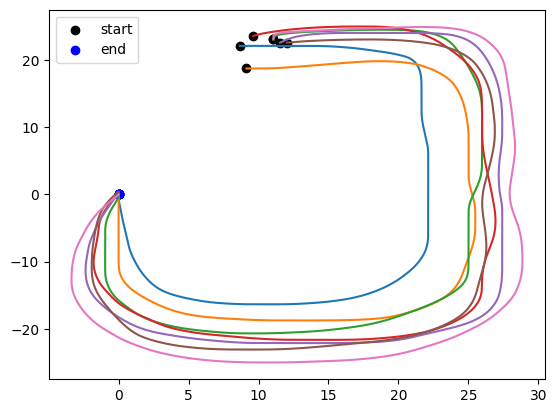

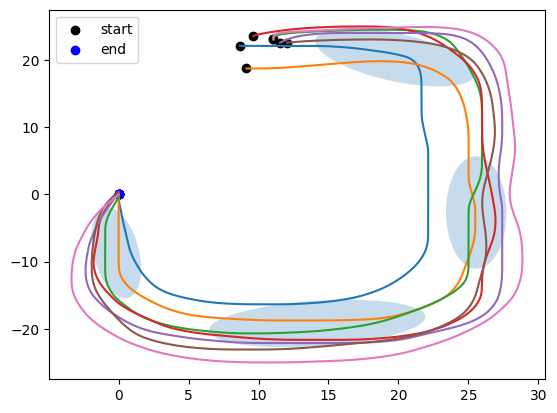

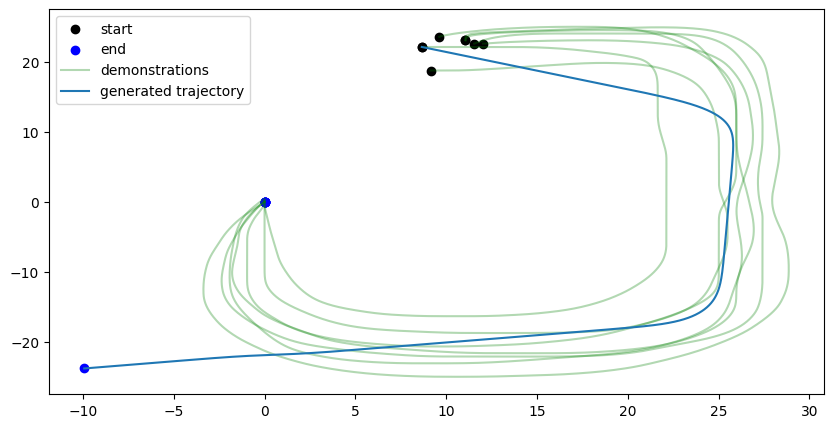

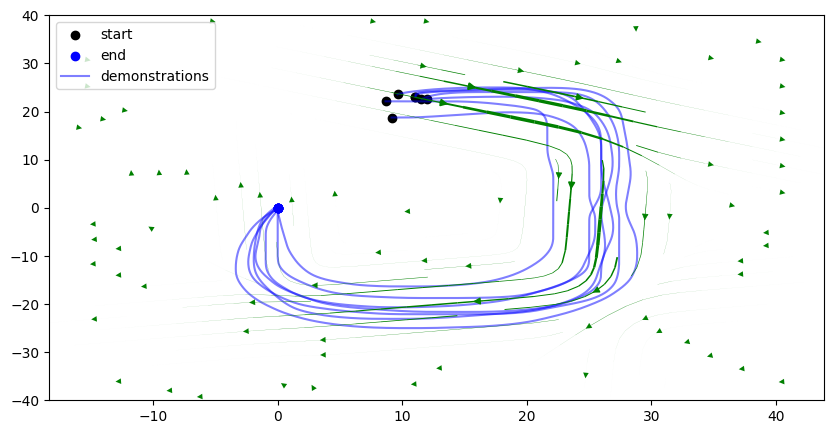

In [10]:
fit_rbfn(dataset="j", n=4, bias=False)

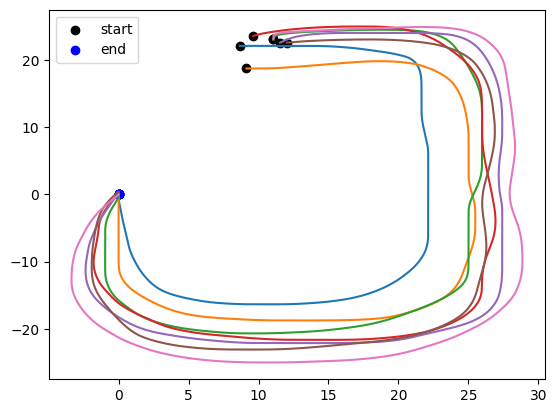

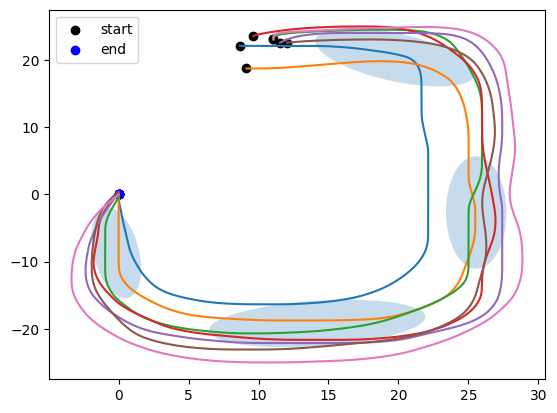

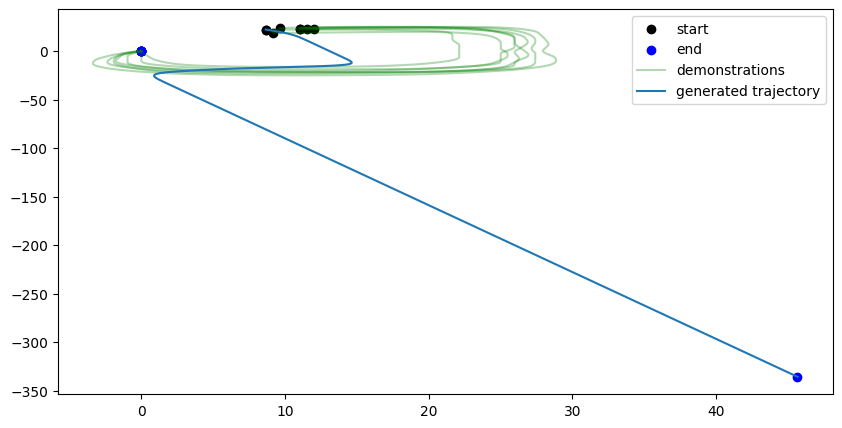

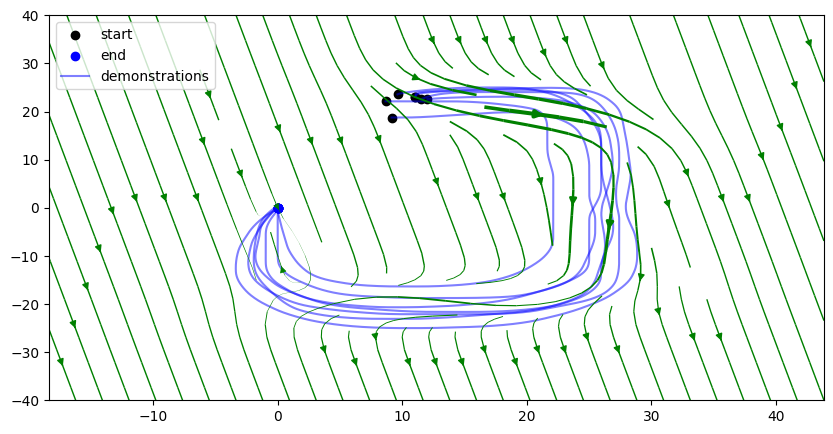

In [11]:
fit_rbfn(dataset="j", n=4, bias=True)

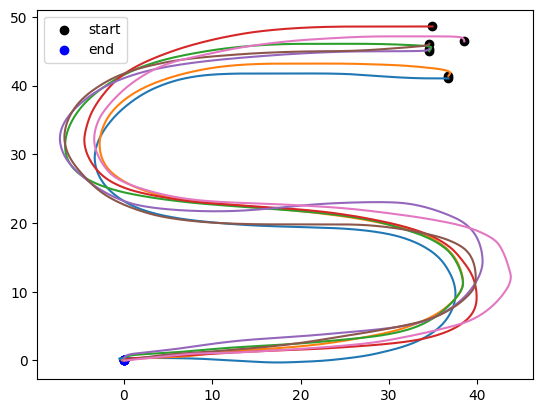

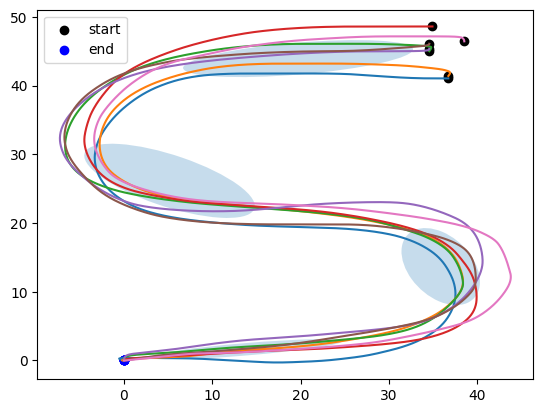

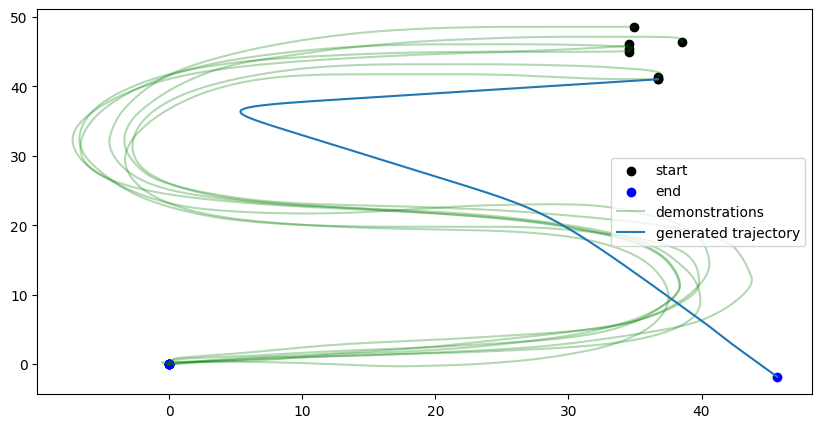

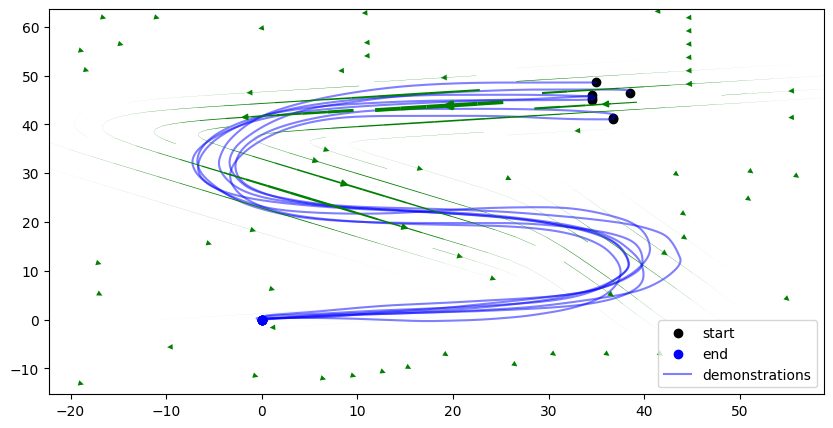

In [12]:
fit_rbfn(dataset="s", n=4, bias=False)

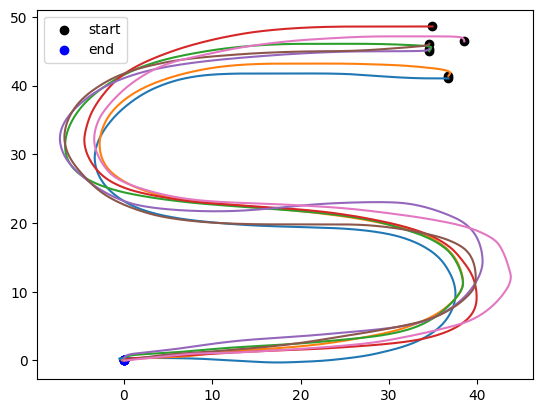

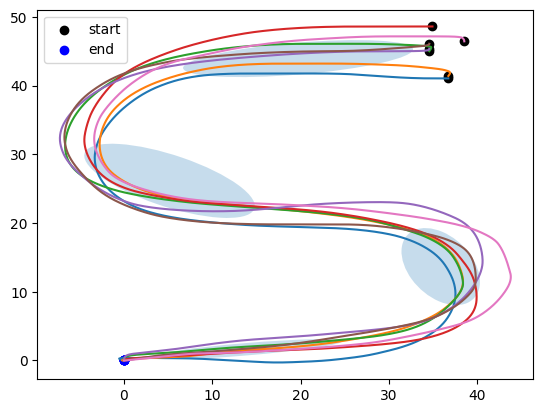

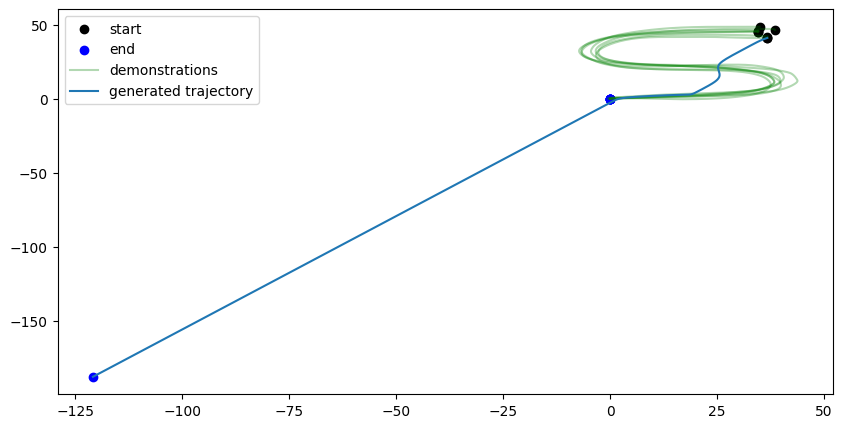

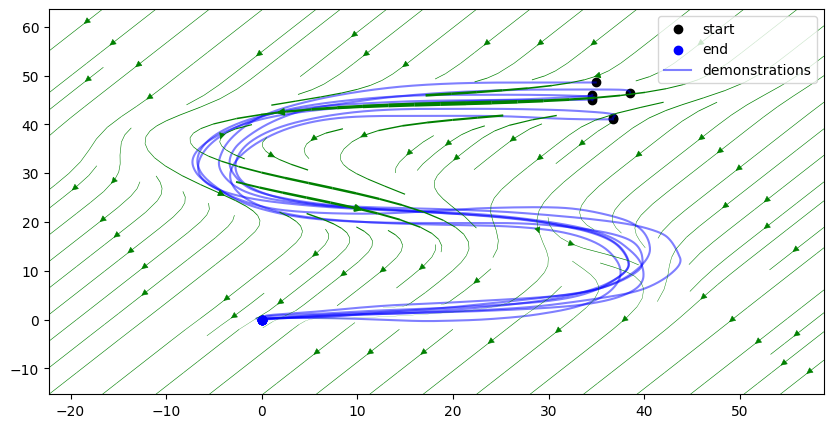

In [13]:
fit_rbfn(dataset="s", n=4, bias=True)

# Submission details

please submit the copy of this file with the naming convention **SRNO(5digit)_Assignment4.ipynb**